# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [59]:
#your code here
train = pd.read_csv("Bikeshare_train.csv", index_col=0)

In [5]:
train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [60]:
test = pd.read_csv("Bikeshare_test.csv", index_col=0)

In [7]:
test.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,1.0,2.0,0.0,4.0,1.0,1.0,2.0,6.0,56.2083,0.194037,3830.0
1,1.0,12.0,0.0,4.0,1.0,2.0,1.0,3.0,65.2917,0.350133,2114.0
2,2.0,6.0,0.0,4.0,1.0,2.0,36.0,37.0,56.8333,0.149883,915.0
3,1.0,2.0,0.0,1.0,1.0,1.0,8.0,12.0,49.0833,0.268033,4322.0
4,2.0,5.0,0.0,0.0,0.0,1.0,28.0,29.0,69.7083,0.215171,6591.0


(array([111.,  45.,  41.,  41.,  93.]),
 array([0. , 1.2, 2.4, 3.6, 4.8, 6. ]),
 <a list of 5 Patch objects>)

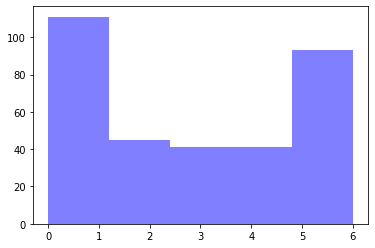

In [8]:
plt.hist(train['day_of_week'], 5, facecolor='blue', alpha=0.5)

In [65]:
train.rename(index=str, columns={"count": "rentals"}, inplace=True) 
test.rename(index=str, columns={"count": "rentals"}, inplace=True)

In [66]:
train.head()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


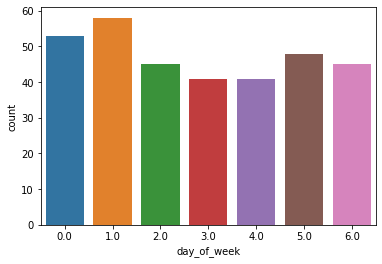

In [67]:
import seaborn as sns
%matplotlib inline

sns.countplot(x='day_of_week',data=train)

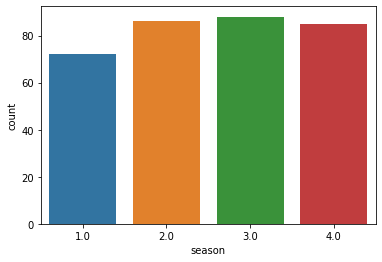

In [12]:
sns.countplot(x='season',data=train)

In [13]:
train.describe()

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,2.561934,6.640483,0.033233,2.854985,0.670695,1.389728,17.018127,19.543807,63.385776,0.190833,4598.447130
std,1.094726,3.353974,0.179515,2.048680,0.470672,0.546962,11.192515,9.930991,14.334789,0.078240,1935.319338
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,7.500000,11.000000,52.702900,0.133083,3370.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000
75%,4.000000,9.500000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.500000,0.235380,5981.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,38.000000,39.000000,97.250000,0.421642,8714.000000


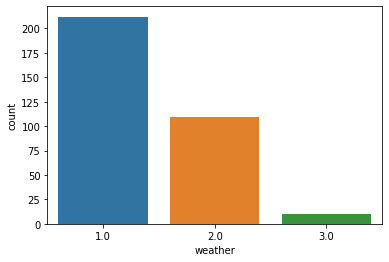

In [14]:
sns.countplot(x='weather',data=train)

<BarContainer object of 331 artists>

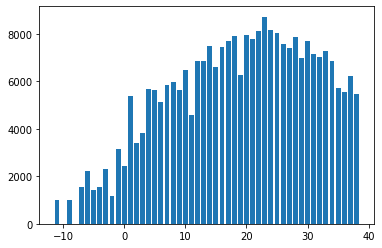

In [15]:
plt.bar(train['temp'], train['rentals']) 

The graph above shows that as the temperature is low, the number of bike rentals decreased. We can clearly see that there is large amount of bike rentals, when the temperature is 23 - 24.

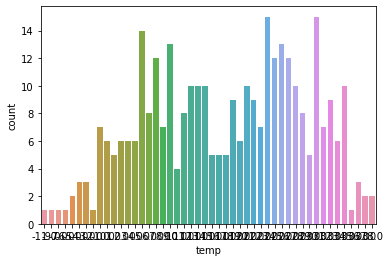

In [16]:
sns.countplot(x='temp',data=train)

<BarContainer object of 331 artists>

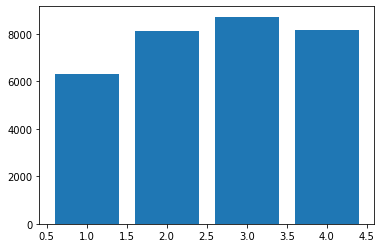

In [23]:
plt.bar(train['season'], train['rentals']) 

<BarContainer object of 331 artists>

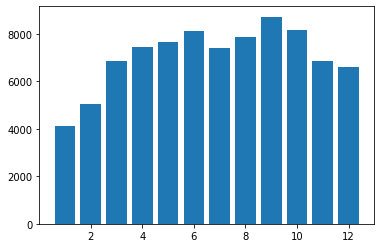

In [24]:
plt.bar(train['month'], train['rentals']) 

<BarContainer object of 331 artists>

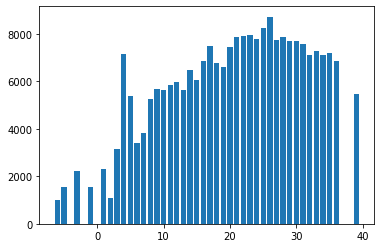

In [25]:
plt.bar(train['atemp'], train['rentals']) 

<BarContainer object of 331 artists>

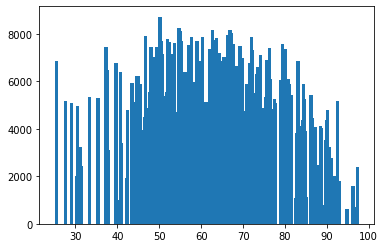

In [26]:
plt.bar(train['humidity'], train['rentals']) 

<BarContainer object of 331 artists>

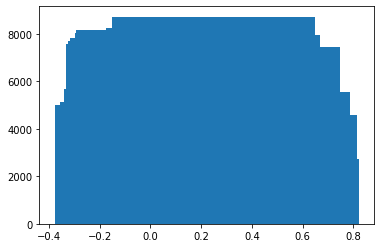

In [27]:
plt.bar(train['windspeed'], train['rentals']) 

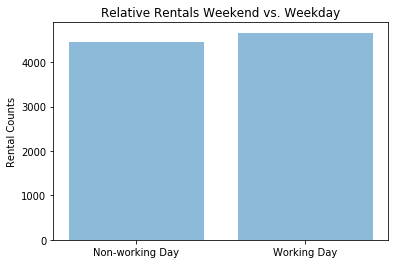

In [28]:
#for getting the average rentals on working day and non-working data

avarage_rentals = [0, 0]

objects = ('0', '1')

x_pos = np.arange(len(objects))

day = [train.loc[train['workingday'] == 0, 'rentals'].sum()]

day.append(train.loc[train['workingday'] == 1,'rentals'].sum())

freq = train['workingday'].value_counts()

avarage_rentals[0] = day[0]/freq[0]

avarage_rentals[1] = day[1]/freq[1]

plt.bar(x_pos, avarage_rentals, align='center', alpha=0.5) 
plt.xticks(x_pos, ['Non-working Day', 'Working Day']) 
plt.ylabel('Rental Counts') 
plt.title('Relative Rentals Weekend vs. Weekday') 
plt.show()

The avarage rentals on a working day and non working are almost same.

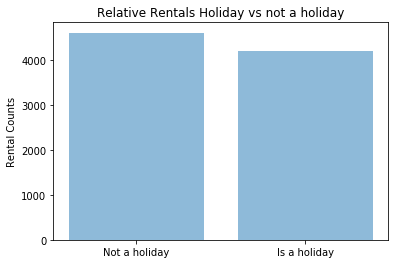

In [29]:
#for getting the average rentals on holiday and not a holiday

avarage_rentals = [0, 0]

objects = ('0', '1')

x_pos = np.arange(len(objects))

day = [train.loc[train['holiday'] == 0, 'rentals'].sum()]

day.append(train.loc[train['holiday'] == 1,'rentals'].sum())

freq = train['holiday'].value_counts()

avarage_rentals[0] = day[0]/freq[0]

avarage_rentals[1] = day[1]/freq[1]

plt.bar(x_pos, avarage_rentals, align='center', alpha=0.5) 
plt.xticks(x_pos, ['Not a holiday', 'Is a holiday']) 
plt.ylabel('Rental Counts') 
plt.title('Relative Rentals Holiday vs not a holiday') 
plt.show()

We can see in the graph above that number of bike rentals on holidays is less and more when there is no holiday

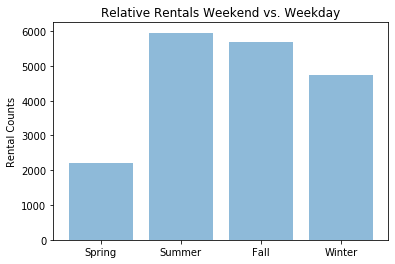

In [30]:
#for getting the average rentals on working day and non-working data

avarage_rentals = [0, 0, 0, 0]

objects = ('1', '2', '3', '4')

x_pos = np.arange(len(objects))

day = [train.loc[train['season'] == 1, 'rentals'].sum()]

day.append(train.loc[train['season'] == 2,'rentals'].sum())

day.append(train.loc[train['season'] == 3,'rentals'].sum())

day.append(train.loc[train['season'] == 4,'rentals'].sum())

freq = train['season'].value_counts()

avarage_rentals[0] = day[0]/freq.iat[1]

avarage_rentals[1] = day[1]/freq.iat[3]

avarage_rentals[2] = day[2]/freq.iat[0]

avarage_rentals[3] = day[3]/freq.iat[2]

plt.bar(x_pos, avarage_rentals, align='center', alpha=0.5) 
plt.xticks(x_pos, ['Spring', 'Summer', 'Fall', 'Winter']) 
plt.ylabel('Rental Counts') 
plt.title('Relative Rentals Weekend vs. Weekday') 
plt.show()

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

In [72]:
test.columns

Index(['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'rentals'],
      dtype='object')

In [74]:
y_train = train['rentals'].values
X_train = train[['holiday', 'season','month','day_of_week','workingday','weather','temp'
                ,'atemp','humidity','windspeed']].values

y_test = test['rentals'].values
X_test = test[['holiday','season','month','day_of_week','workingday','weather','temp','atemp','humidity','windspeed']].values

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [75]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
print(X_train.shape, y_train.shape, X_test.shape , y_test.shape)

(331, 10) (331, 1) (400, 10) (400, 1)


In [81]:
X_train_lm = X_train
y_train_lm = y_train


lm_1 = LinearRegression(fit_intercept=True)
lm_1.fit(X_train, y_train)

y_pred = lm_1.predict(X_test)

print('The equation of the regression plane is: {} + {}^T . x'.format(lm_1.intercept_, lm_1.coef_))

The equation of the regression plane is: [4352.16862916] + [[ -323.48649012   470.93789715   -28.96086316    85.39355534
    130.21449762  -417.64711445    35.83736735    62.03656361
    -28.12808922 -2867.83535287]]^T . x


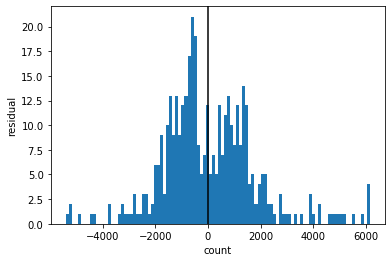

In [82]:
# Residual plot
plt.hist(y_test - y_pred, bins=100)
plt.axvline(x=0, color = "black")
plt.ylabel('residual')
plt.xlabel('count')
plt.show()

In [79]:
# your code here
#x train contains all the values in data frame except the rentals
#same with the test
Xtrain, ytrain = train.drop('rentals', axis =1), train['rentals'].values.reshape(-1,1)
Xtest, ytest = test.drop('rentals', axis =1), test['rentals'].values.reshape(-1, 1)

#building a multiple linear regression we have to fit some constant and fit the model
mult_reg = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()

ytest_pred = mult_reg.predict(sm.add_constant(Xtest))
ytrain_pred = mult_reg.predict(sm.add_constant(Xtrain))

In [80]:
print(mult_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     32.23
Date:                Sat, 10 Aug 2019   Prob (F-statistic):           7.29e-43
Time:                        10:45:26   Log-Likelihood:                -2858.9
No. Observations:                 331   AIC:                             5740.
Df Residuals:                     320   BIC:                             5782.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4352.1686    556.349      7.823      

your answers here

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed
season,1.000000,0.850795,-0.018215,-0.039220,-0.016169,-0.017659,0.308064,0.317435,0.199211,-0.241311
month,0.850795,1.000000,0.019904,-0.058327,-0.044510,-0.022502,0.210458,0.220412,0.186807,-0.235166
holiday,-0.018215,0.019904,1.000000,-0.143411,-0.264597,-0.070582,0.020814,0.015329,0.004507,-0.019892
day_of_week,-0.039220,-0.058327,-0.143411,1.000000,0.085459,0.028955,-0.011515,-0.028433,-0.019374,0.015946
workingday,-0.016169,-0.044510,-0.264597,0.085459,1.000000,0.099822,0.062111,0.059173,0.093130,-0.034752
weather,-0.017659,-0.022502,-0.070582,0.028955,0.099822,1.000000,-0.140746,-0.141227,0.640794,0.044730
temp,0.308064,0.210458,0.020814,-0.011515,0.062111,-0.140746,1.000000,0.983897,0.138839,-0.148885
atemp,0.317435,0.220412,0.015329,-0.028433,0.059173,-0.141227,0.983897,1.000000,0.146056,-0.172064
humidity,0.199211,0.186807,0.004507,-0.019374,0.093130,0.640794,0.138839,0.146056,1.000000,-0.235940
windspeed,-0.241311,-0.235166,-0.019892,0.015946,-0.034752,0.044730,-0.148885,-0.172064,-0.235940,1.000000


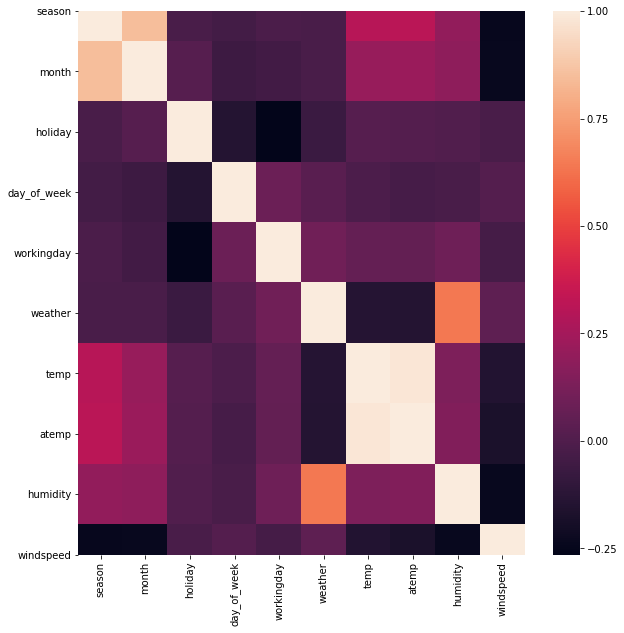

In [34]:
# your code here

corr = train.drop('rentals', axis = 1).corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr)

corr

temp and atemp has multi-collinearity season and months also exhibit mulit-collineairty

your answers here

## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [35]:
# your code here

# your code here

p_values = mult_reg.summary2().tables[1]['P>|t|']
p_values= p_values.sort_values()

print(p_values)

const          7.583706e-14
humidity       3.657555e-04
season         7.222613e-04
windspeed      7.391276e-03
day_of_week    2.518451e-02
weather        3.638569e-02
atemp          1.577799e-01
temp           3.547390e-01
workingday     4.448486e-01
holiday        4.707437e-01
month          5.101427e-01
Name: P>|t|, dtype: float64


from the above table we can observe the significance of all the features which are very relevant to predict the bike rentals

some of the significant features are humidity, season, windspeed and day of the week

your answers here

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Evaluate each of the 3 models on the provided left out test set by calculating $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [36]:
# your code here

train.head(5)

,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,rentals
0,2.0,5.0,0.0,2.0,1.0,2.0,24.0,26.0,76.5833,0.118167,6073.0
1,4.0,12.0,0.0,2.0,1.0,1.0,15.0,19.0,73.3750,0.174129,6606.0
2,2.0,6.0,0.0,4.0,1.0,1.0,26.0,28.0,56.9583,0.253733,7363.0
3,4.0,12.0,0.0,0.0,0.0,1.0,0.0,4.0,58.6250,0.169779,2431.0
4,3.0,9.0,0.0,3.0,1.0,3.0,23.0,23.0,91.7083,0.097021,1996.0


In [46]:
from sklearn.linear_model import LinearRegression
X_train = train[['holiday', 'workingday', 'temp', 'humidity', 'season', 'day_of_week']].values

X_test = test[['holiday', 'workingday', 'temp', 'humidity',  'season', 'day_of_week']].values


lm = LinearRegression()
lm.fit(X_train, ytrain)

y_pred = lm.predict(X_test)

In [49]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lm, X_train, ytrain, cv = 10)
lm_avg = np.mean(scores)
print('Cross-validated scores', scores, 'Average of folds', lm_avg)

Cross-validated scores [ 0.57521568  0.42541919  0.28979633 -0.00831534  0.36866027  0.49516293
  0.28944237  0.31634679  0.58625154  0.55048747] Average of folds 0.38884672330552


your answers here

In [85]:
# second model
scores = cross_val_score(lm_1, Xtrain, ytrain, cv=10)
lm_1_avg = np.mean(scores)
print('Cross-validated scores', scores, 'Average of folds', lm_1_avg)

Cross-validated scores [ 0.61544437  0.49943844  0.34796465  0.01423012  0.44806417 -0.49662574
  0.3166238   0.37104866  0.54119654  0.56859189] Average of folds 0.3225976888005126


In [86]:
# your code here
#x train contains all the values in data frame except the rentals
#same with the test
Xtrain, ytrain = train.drop(['rentals','holiday','workingday','temp','month'], axis =1), train['rentals'].values.reshape(-1,1)
Xtest, ytest = test.drop(['rentals','holiday','temp', 'workingday', 'month'], axis =1), test['rentals'].values.reshape(-1, 1)


#building a multiple linear regression we have to fit some constant and fit the model
mult_reg = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()

ytest_pred = mult_reg.predict(sm.add_constant(Xtest))
ytrain_pred = mult_reg.predict(sm.add_constant(Xtrain))

C:\Users\DELL\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [87]:
print(mult_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     53.42
Date:                Sat, 10 Aug 2019   Prob (F-statistic):           1.37e-45
Time:                        10:48:21   Log-Likelihood:                -2860.4
No. Observations:                 331   AIC:                             5735.
Df Residuals:                     324   BIC:                             5761.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4177.9706    501.185      8.336      